# EDA & Visualisation

In [ ]:
%reset

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from datetime import date
import holidays
sns.set()
import warnings
warnings.filterwarnings("ignore")

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = "Verdana"
mpl.rcParams["lines.markersize"] = 20

## Incident File

Incident data of Kwinana Fwy (Inner) northbound from 2018-01-01 00:00:00 to 2018-10-25 23:59:00

In [3]:
df1 = pd.read_csv('data/Kwinana_Fwy_Historic_Incidents_2018_Wide.csv')
df1 = df1[df1.Incident_Type != 'Duplicate Entry']
df1 = df1.reset_index(drop=True)
df1.WST_Start = pd.to_datetime(df1.WST_Start)
df1.WST_End = pd.to_datetime(df1.WST_End)
df1.Incident_Type = df1.Incident_Type.str.replace('/', '/\n')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OBJECTID          371 non-null    int64         
 1   Lat               371 non-null    float64       
 2   Long              371 non-null    float64       
 3   WST_Start         371 non-null    datetime64[ns]
 4   WST_End           371 non-null    datetime64[ns]
 5   Incident_Type     371 non-null    object        
 6   TrafficCondition  371 non-null    object        
 7   Congestion        371 non-null    object        
 8   Duration          371 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 26.2+ KB


In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.barplot(x=df1.Incident_Type.value_counts(),
           y=df1.Incident_Type.value_counts().index)
ax.set_xlabel('Frequency')
ax.set_xlim(right=200)
for p in ax.patches:
  width = p.get_width()
  ax.text(width + 1,
          p.get_y() + p.get_height()/2,
          int(width),
          ha="left",
          va="center")
#plt.savefig('fig/incident_type_1.png', bbox_inches="tight")
plt.show()

Since Special Event, Pothole / Road Surface Damage, and Hazmat (including spills) did not affect traffic congestion, these three categories are combined into one category called 'Special Event / Pothole / Hazmat'

Also, Flooding and Storm are combined into one category called 'Flooding / Storm'

In [4]:
df1.Incident_Type=df1.Incident_Type.replace(['Special Event',
                                            'Pothole /\n Road Surface Damage',
                                            'Hazmat (including spills)'],
                                           'Special Event /\nPothole / Hazmat')

df1.Incident_Type=df1.Incident_Type.replace(['Flooding', 'Storm'],
                                           'Flooding /\nStorm')

In [ ]:
cmp = mpl.colors.ListedColormap(['#4053d3', '#00b25d', '#b51d14', '#ddb310'])

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=df1.Incident_Type.value_counts(),
           y=df1.Incident_Type.value_counts().index,
                palette=['#4053d3', '#00b25d', '#b51d14', '#ddb310'])
ax.set_ylabel('Incident Type', size=18)
ax.set_xlabel('Frequency', size=18)
ax.set_xlim(right=200)
for p in ax.patches:
  width = p.get_width()
  ax.text(width + 12,
          p.get_y() + p.get_height()/2,
          str(int(width)) + '\n(' + str(np.round(width/371*100, 1)) + '%)',
          ha="center",
          va="center")
plt.savefig('fig/incident_type.png', bbox_inches="tight")
plt.show()

In [5]:
df1.Incident_Type = df1.Incident_Type.replace([
    'Flooding /\nStorm', 'Special Event /\nPothole / Hazmat',
    'Special Event /\nPothole / Hazmat', 'Animal /\n Livestock',
    'Vehicle Fire'], 'Miscellaneous')

In [ ]:
temp2 = df1.groupby(['Incident_Type', 'Congestion']).size().unstack()
temp2['sum'] = temp2.sum(axis=1)

plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 16})

cmp = mpl.colors.ListedColormap(['#efe645', '#e1562c', '#537eff'])

ax=(temp2.sort_values(by='sum').iloc[:,:-1]
    .plot(kind='barh', stacked=True, width=0.7,
          cmap=cmp))
ax.set_xlim(right=200)
ax.set_ylabel('Incident Type', size=18)
ax.set_xlabel('Frequency', size=18)
ax.legend(title='')
for i, v in enumerate(temp2.sort_values('sum')['sum']):
    ax.text(v+12, i, 
            str(int(v)) + '\n(' + str(np.round(v/temp2['sum'].sum()*100, 1)) + '%)',
            va = 'center', ha = 'center', fontsize = 14)
    
for n in temp2.iloc[:,:-1]: # for each column
    for i, (cs, ab) in enumerate(zip(temp2.sort_values(by='sum').cumsum(1)[n], 
                                     temp2.sort_values(by='sum')[n])):
        if ~np.isnan(cs) and ab > 4:
            ax.text(cs - ab / 2, i,
                 str(int(ab)) + '\n(' + str(np.round(ab/temp2['sum'].sum()*100, 1)) + '%)', 
                 va = 'center', ha = 'center', rotation = 20, fontsize = 12)   

plt.savefig('fig/incident_congestion_2.png', bbox_inches="tight")
plt.show()

In [6]:
df1.TrafficCondition=df1.TrafficCondition.replace(['Left Emergency Lane Blocked',
                                             'Right Emergency Lane Blocked'],
                                             'Emergency Lane Blocked')

df1.TrafficCondition=df1.TrafficCondition.replace(['Left Lane(s) Blocked',
                                             'Right Lane(s) Blocked',
                                             'Centre Lane(s) Blocked',
                                             'Left Centre Lane(s) Blocked',
                                             'Right Centre Lane(s) Blocked',
                                             'Bus Lane Blocked'],
                                             'Lane(s) Blocked')

df1.TrafficCondition=df1.TrafficCondition.replace(['Left Turning Pocket Blocked',
                                             'Right Turning Pocket Blocked'],
                                             'Turning Pocket Blocked')

In [ ]:
temp2 = df1.groupby(['Incident_Type', 'TrafficCondition']).size().unstack()
temp2['sum'] = temp2.sum(axis=1)

plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 16})

cmp = mpl.colors.ListedColormap(['#00cb85', '#efe645', '#537eff',
                                '#e1562c', '#00e3ff'])

ax=(temp2.sort_values(by='sum').iloc[:,:-1]
    .plot(kind='barh', stacked=True, width=0.7,
          cmap=cmp))
ax.set_xlim(right=200)
ax.set_ylabel('Incident Type', size=18)
ax.set_xlabel('Frequency', size=18)
ax.legend(title='Traffic Condition')
for i, v in enumerate(temp2.sort_values('sum')['sum']):
    ax.text(v+12, i, 
            str(int(v)) + '\n(' + str(np.round(v/temp2['sum'].sum()*100, 1)) + '%)',
            va = 'center', ha = 'center', fontsize = 14)
    
for n in temp2.iloc[:,:-1]: # for each column
    for i, (cs, ab) in enumerate(zip(temp2.sort_values(by='sum').cumsum(1)[n], 
                                     temp2.sort_values(by='sum')[n])):
        if ~np.isnan(cs) and ab > 6:
            ax.text(cs - ab / 2, i,
                 str(int(ab)) + '\n(' + str(np.round(ab/temp2['sum'].sum()*100, 1)) + '%)', 
                 va = 'center', ha = 'center', rotation = 20, fontsize = 12)   

#plt.savefig('fig/incident_condition_2.png', bbox_inches="tight")
plt.show()

In [ ]:
temp2 = df1.groupby(['TrafficCondition', 'Congestion']).size().unstack()
temp2['sum'] = temp2.sum(axis=1)

plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 16})

cmp = mpl.colors.ListedColormap(['#efe645', '#e1562c', '#537eff'])

ax=(temp2.sort_values(by='sum').iloc[:,:-1]
    .plot(kind='barh', stacked=True, width=0.7,
          cmap=cmp))
ax.set_xlim(right=200)
ax.set_ylabel('Traffic Condition', size=18)
ax.set_xlabel('Frequency', size=18)
ax.legend(title='')
for i, v in enumerate(temp2.sort_values('sum')['sum']):
    ax.text(v+12, i, 
            str(int(v)) + '\n(' + str(np.round(v/temp2['sum'].sum()*100, 1)) + '%)',
            va = 'center', ha = 'center', fontsize = 14)
    
for n in temp2.iloc[:,:-1]: # for each column
    for i, (cs, ab) in enumerate(zip(temp2.sort_values(by='sum').cumsum(1)[n], 
                                     temp2.sort_values(by='sum')[n])):
        if ~np.isnan(cs) and ab > 6:
            ax.text(cs - ab / 2, i,
                 str(int(ab)) + '\n(' + str(np.round(ab/temp2['sum'].sum()*100, 1)) + '%)', 
                 va = 'center', ha = 'center', rotation = 20, fontsize = 12)   

#plt.savefig('fig/condition_congestion.png', bbox_inches="tight")
plt.show()

In [7]:
def func2(a):
    if -32.091154 <= a < -32.080696:
        return "1"
    elif -32.080696 <= a < -32.074042:
        return "2"
    elif -32.074042 <= a < -32.071075:
        return "3"
    elif -32.071075 <= a < -32.057092:
        return "4"
    elif -32.057092 <= a < -32.052286:
        return "5"
    elif -32.052286 <= a < -32.043637:
        return "6"
    elif -32.043637 <= a < -32.040758:
        return "7"
    elif -32.040758 <= a < -32.030254:
        return "8"
    elif -32.030254 <= a < -32.012242:
        return "9"
    elif -32.012242 <= a < -32.010690:
        return "10"
    elif -32.010690 <= a < -32.003147:
        return "11"
    elif -32.003147 <= a < -31.969905:
        return "12"
    elif -31.969905 <= a < -31.966753:
        return "13"
    elif a >= -31.966753 :
        return "14"
    else:
        return "Other"

df1['ID'] = df1['Lat'].apply(lambda x: func2(x))
df1.ID = df1.ID.astype(int)
df1.head()

,OBJECTID,Lat,Long,WST_Start,WST_End,Incident_Type,TrafficCondition,Congestion,Duration,ID
0,11402,-31.967082,115.846103,2018-01-01 16:21:00,2018-01-01 16:59:00,Break Down /\n Tow Away,Lane(s) Blocked,Congestion,38.0,13
1,11443,-32.033494,115.858312,2018-01-03 15:41:00,2018-01-03 15:56:00,Break Down /\n Tow Away,Emergency Lane Blocked,No Known Congestion,15.0,8
2,11475,-32.025228,115.859856,2018-01-04 17:10:00,2018-01-04 19:20:00,Break Down /\n Tow Away,Emergency Lane Blocked,No Known Congestion,130.0,9
3,11487,-32.043923,115.854653,2018-01-05 05:19:00,2018-01-05 05:58:00,Road Crash,Lane(s) Blocked,Congestion,39.0,6
4,11554,-32.011120,115.856484,2018-01-09 09:10:00,2018-01-09 09:40:00,Debris /\n Trees /\n Lost Loads,Lane(s) Blocked,No Known Congestion,30.0,10


In [ ]:
df1.describe()

In [ ]:
temp2 = df1.groupby(['ID', 'Incident_Type']).size().unstack()
temp2['sum'] = temp2.sum(axis=1)

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 16})

cmp = mpl.colors.ListedColormap(['#4053d3', '#00b25d', '#ddb310', '#b51d14'])

ax=(temp2.sort_values(by='sum').iloc[:,:-1]
    .plot(kind='barh', stacked=True, width=0.7,
          cmap=cmp))
ax.set_xlim(right=90)
ax.set_ylabel('Link', size=18)
ax.set_xlabel('Frequency', size=18)
ax.legend(title='Incident Type')
for i, v in enumerate(temp2.sort_values('sum')['sum']):
    ax.text(v+5, i, 
            str(int(v)) + '\n(' + str(np.round(v/temp2['sum'].sum()*100, 1)) + '%)',
            va = 'center', ha = 'center', fontsize = 12)
    
for n in temp2.iloc[:,:-1]: # for each column
    for i, (cs, ab) in enumerate(zip(temp2.sort_values(by='sum').cumsum(1)[n], 
                                     temp2.sort_values(by='sum')[n])):
        if ~np.isnan(cs) and ab >= 5:
            ax.text(cs - ab / 2, i-.01,
                 str(int(ab)) + '\n(' + str(np.round(ab/temp2['sum'].sum()*100, 1)) + '%)', 
                 va = 'center', ha = 'center', rotation=15, fontsize = 11)   

#plt.savefig('fig/incident_link_2.png', bbox_inches="tight")
plt.show()

In [ ]:
del temp2

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(1, ncolors+1))
    colorbar.set_label('Link')
    
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)


cmp = mpl.colors.ListedColormap(['#ebac23', '#b80058', '#008cf9',
                                 '#006e00', '#00bbad', '#d163e6',
                                 '#b24502', '#ff9287', '#5954d6',
                                 '#00c6f8', '#878500', '#00a76c',
                                 '#bdbdbd', '#000078', '#b51d14'])
df1.plot(kind='scatter', x='Long', y='Lat', alpha=0.5,
        s='Duration', c='ID', label='Duration',
        cmap=cmp, colorbar=False, rot=45)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(markerscale=0.2)
colorbar_index(ncolors=14, cmap=cmp)
#plt.savefig('fig/incident_loc_link_2.png', bbox_inches="tight")
plt.show()

## Traffic + Incident data

In [3]:
df = pd.read_csv('data/LAD+incident2.csv', index_col=0)
df.DateTime = pd.to_datetime(df.DateTime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6007680 entries, 0 to 6007679
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ID                int64         
 1   DateTime          datetime64[ns]
 2   Length            float64       
 3   Volume            float64       
 4   Speed             float64       
 5   Occupancy         float64       
 6   Incident_Type     object        
 7   TrafficCondition  object        
 8   Congestion        object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 458.3+ MB


In [ ]:
df.head()

In [ ]:
df.iloc[:,3:6] \
    .describe() \
    .apply(lambda s: s.apply('{0:.4f}'.format))

In [ ]:
df.iloc[:,2:6].corr()

- Moderate positive correlation between volume and occupancy
- High negative correlation between speed and occupancy

In [ ]:
# pd.plotting.scatter_matrix(df.iloc[:,3:6], alpha=0.05)
# plt.show()

In [ ]:
# variables = ['Volume', 'Speed', 'Occupancy']
# g = sns.PairGrid(df, hue="Volume", vars=variables)
# g.map_diag(sns.histplot, hue=None, color=".3")
# g.map_offdiag(sns.scatterplot)
# g.add_legend()

In [ ]:
# df.iloc[:,3:6].plot.box(figsize=(6,6))
# plt.show()

In [ ]:
# plt.rcParams.update({'font.size': 14,
#                     'lines.markersize': 5})
# fig, ax = plt.subplots(1, 3, figsize=(6,8))
# ax.boxplot(df.Volume)
# ax.boxplot(df.Speed)
# ax.boxplot(df.Occupancy)

# plt.show()

### Prepare the data for deep learning algorithms

In [4]:
# Drop Congestion column
df.drop('Congestion', axis=1, inplace=True)

In [ ]:
# NaN TrafficCondition == 'All Lanes Open'

df.TrafficCondition = df.TrafficCondition.replace({
    np.nan: 'All Lanes Open',
    'All Lanes Open, Emergency Lane Blocked': 'Emergency Lane Blocked',
    'Lane Closures Unknown, Lane(s) Blocked': 'Lane(s) Blocked',
    'Lane(s) Blocked, All Lanes Open': 'Lane(s) Blocked',
    'All Lanes Open, Lane(s) Blocked': 'Lane(s) Blocked',
    'Emergency Lane Blocked, Emergency Lane Blocked': 'Emergency Lane Blocked',
    'Lane Closures Unknown, All Lanes Open': 'All Lanes Open',
    'Lane(s) Blocked, Lane(s) Blocked': 'Lane(s) Blocked'
})

df.TrafficCondition.value_counts()

In [ ]:
df.Incident_Type.value_counts()

In [ ]:
df.Incident_Type = df.Incident_Type.replace([
    'Flooding /\nStorm', 'Special Event /\nPothole / Hazmat',
    'Special Event /\nPothole / Hazmat', 'Animal /\n Livestock',
    'Vehicle Fire'], 'Miscellaneous')

df.Incident_Type = df.Incident_Type.replace({
    'Flooding /\nStorm, Road Crash': 'Road Crash, Miscellaneous',
    'Miscellaneous, Break Down /\n Tow Away': 'Break Down /\n Tow Away, Miscellaneous',
    'Flooding /\nStorm, Break Down /\n Tow Away': 'Break Down /\n Tow Away, Miscellaneous',
})
df.Incident_Type.value_counts()

In [ ]:
df['Num_Incidents'] = df.Incident_Type.str.count(', ')
df['Num_Incidents'] = df['Num_Incidents'] + 1
df['Num_Incidents'] = df['Num_Incidents'].replace(np.nan, 0)
df['Num_Incidents'].value_counts()

In [ ]:
df[['Incident_Type1','Incident_Type2']]=df['Incident_Type'].str.split(', ', 1, expand=True)

In [ ]:
df.Incident_Type1 = df.Incident_Type1.replace(np.nan, 'None')
df.Incident_Type2 = df.Incident_Type2.replace(np.nan, 'None')

df.Incident_Type1.value_counts()

In [ ]:
df.Incident_Type2.value_counts()

In [ ]:
# Drop Incident_Type column
df.drop('Incident_Type', axis=1, inplace=True)

In [ ]:
df.Incident_Type1 = df.Incident_Type1.replace({
    'None':'None1',
    'Break Down /\n Tow Away':'BDTA1',
    'Debris /\n Trees /\n Lost Loads':'DTLL1',
    'Road Crash':'RC1',
    'Miscellaneous':'Misc1'
})
df.Incident_Type2 = df.Incident_Type2.replace({
    'None':'None2',
    'Break Down /\n Tow Away':'BDTA2',
    'Debris /\n Trees /\n Lost Loads':'DTLL2',
    'Road Crash':'RC2',
    'Miscellaneous':'Misc2'
})

In [ ]:
df.Incident_Type1.value_counts()

In [ ]:
df.Incident_Type2.value_counts()

In [ ]:
df.info()

#### Link 11

Consider

- Link-11's full data and Link-12's incidents (downstream)
- Incident_Type1, Incident_Type2
    + No Incidents
    + Break Down / Tow Away
    + Debris / Trees / Lost Loads
    + Road Crash
    + miscellaneous: everything else

In [ ]:
df11 = df[df.ID==11]
df12 = df[df.ID==12]

In [ ]:
df11.drop('ID', axis=1, inplace=True)
df11 = df11.set_index('DateTime')
df11.index = pd.to_datetime(df11.index)
if not df11.index.is_monotonic:
    df11 = df11.sort_index()

df11.info()

In [ ]:
from sklearn.preprocessing import LabelBinarizer

cond_enc = LabelBinarizer()
inc1_enc = LabelBinarizer()

df11 = df11.join(pd.DataFrame(cond_enc.fit_transform(df11['TrafficCondition']),
                             columns=cond_enc.classes_,
                             index=df11.index))

df11 = df11.join(pd.DataFrame(inc1_enc.fit_transform(df11['Incident_Type1']),
                             columns=inc1_enc.classes_,
                             index=df11.index))

In [ ]:
df11['RC2'] = df11.Incident_Type2 == 'RC2'
df11['RC2'] = df11['RC2'].astype(int)
df11.RC2.value_counts()

In [ ]:
df11.Incident_Type1.value_counts()

In [ ]:
df11.info()

In [ ]:
df12.info()

In [ ]:
df12.Incident_Type1.value_counts()

In [ ]:
df12['Downstream_Incident'] = (df12.Incident_Type1 != 'None1').astype(int)
df12.Downstream_Incident.value_counts()

In [ ]:
import datetime
df12.DateTime = df12.DateTime - datetime.timedelta(minutes=2)
df12.head()

In [ ]:
df12 = df12[['DateTime', 'Downstream_Incident']]
df12.info()

In [ ]:
df11ds = pd.merge(df11, df12, how='left', on=['DateTime'])
df11ds.Downstream_Incident.value_counts()

In [ ]:
df11ds.to_csv('data/df11ds.csv')

##### Explore Link 11

In [9]:
inc11 = df1[df1.ID == 11]

In [17]:
inc11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 10 to 363
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OBJECTID          56 non-null     int64         
 1   Lat               56 non-null     float64       
 2   Long              56 non-null     float64       
 3   WST_Start         56 non-null     datetime64[ns]
 4   WST_End           56 non-null     datetime64[ns]
 5   Incident_Type     56 non-null     object        
 6   TrafficCondition  56 non-null     object        
 7   Congestion        56 non-null     object        
 8   Duration          56 non-null     float64       
 9   ID                56 non-null     int32         
dtypes: datetime64[ns](2), float64(3), int32(1), int64(1), object(3)
memory usage: 4.6+ KB


In [40]:
inc11['WST_Start'].dt.date.unique().shape

(47,)

- There are 56 incidents occurred on link 11
- 47 days that incidents(s) occurred between 1 Jan 2018 - 25 Oct 2018

In [81]:
inc12 = df1[df1.ID == 12]
inc12.tail(16)

,OBJECTID,Lat,Long,WST_Start,WST_End,Incident_Type,TrafficCondition,Congestion,Duration,ID
291,17130,-31.985795,115.851867,2018-08-24 10:20:00,2018-08-24 10:50:00,Break Down /\n Tow Away,Emergency Lane Blocked,No Known Congestion,30.0,12
294,17202,-31.975624,115.847940,2018-08-27 09:08:00,2018-08-27 10:31:00,Road Crash,Emergency Lane Blocked,Heavy Congestion,83.0,12
295,17210,-31.993950,115.855075,2018-08-27 11:19:00,2018-08-27 11:37:00,Break Down /\n Tow Away,Emergency Lane Blocked,No Known Congestion,18.0,12
298,17280,-31.998825,115.854729,2018-08-29 07:35:00,2018-08-29 08:31:00,Miscellaneous,All Lanes Open,Congestion,56.0,12
300,17302,-31.982177,115.849986,2018-08-29 13:50:00,2018-08-29 14:09:00,Break Down /\n Tow Away,Lane(s) Blocked,Heavy Congestion,19.0,12
303,17357,-31.970108,115.846784,2018-08-31 08:31:00,2018-08-31 09:06:00,Break Down /\n Tow Away,Lane(s) Blocked,Congestion,35.0,12
310,17506,-31.980067,115.848541,2018-09-06 07:28:00,2018-09-06 07:42:00,Break Down /\n Tow Away,Emergency Lane Blocked,Congestion,14.0,12
313,17652,-31.997180,115.854951,2018-09-11 14:59:00,2018-09-11 15:12:00,Miscellaneous,All Lanes Open,Heavy Congestion,13.0,12
316,17822,-31.987938,115.853117,2018-09-18 15:15:00,2018-09-18 15:28:00,Road Crash,Lane(s) Blocked,Heavy Congestion,13.0,12
319,17870,-31.971104,115.847188,2018-09-20 08:18:00,2018-09-20 09:00:00,Road Crash,Lane(s) Blocked,Congestion,42.0,12


In [13]:
inc11.tail(10)

,OBJECTID,Lat,Long,WST_Start,WST_End,Incident_Type,TrafficCondition,Congestion,Duration,ID
289,17103,-32.003310,115.853584,2018-08-23 14:20:00,2018-08-23 15:03:00,Debris /\n Trees /\n Lost Loads,All Lanes Open,No Known Congestion,43.0,11
296,17213,-32.007125,115.854750,2018-08-27 12:02:00,2018-08-27 12:26:00,Road Crash,Lane(s) Blocked,Heavy Congestion,24.0,11
297,17215,-32.006326,115.854393,2018-08-27 12:50:00,2018-08-27 13:30:00,Miscellaneous,All Lanes Open,No Known Congestion,40.0,11
301,17320,-32.008052,115.855026,2018-08-29 21:50:00,2018-08-29 22:27:00,Debris /\n Trees /\n Lost Loads,Emergency Lane Blocked,No Known Congestion,37.0,11
309,17505,-32.006220,115.854366,2018-09-06 07:12:00,2018-09-06 07:27:00,Break Down /\n Tow Away,Emergency Lane Blocked,No Known Congestion,15.0,11
326,18010,-32.007614,115.854915,2018-09-25 20:33:00,2018-09-25 20:38:00,Break Down /\n Tow Away,Lane(s) Blocked,No Known Congestion,5.0,11
346,18301,-32.007443,115.854917,2018-10-08 08:38:00,2018-10-08 09:07:00,Debris /\n Trees /\n Lost Loads,All Lanes Open,Heavy Congestion,29.0,11
347,18302,-32.006892,115.854599,2018-10-08 08:46:00,2018-10-08 08:55:00,Road Crash,Emergency Lane Blocked,Heavy Congestion,9.0,11
362,18572,-32.003492,115.853576,2018-10-19 08:58:00,2018-10-19 08:58:00,Break Down /\n Tow Away,Emergency Lane Blocked,Congestion,0.0,11
363,18580,-32.009027,115.855259,2018-10-19 13:59:00,2018-10-19 15:10:00,Debris /\n Trees /\n Lost Loads,All Lanes Open,No Known Congestion,71.0,11


In [ ]:
df = pd.read_csv('data/df11ds.csv', index_col=0)
df.info()

In [42]:
df.DateTime = pd.to_datetime(df.DateTime, format="%Y-%m-%d %H:%M:%S")
# Set DateTime as index and sort
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429120 entries, 2018-01-01 00:00:00 to 2018-10-25 23:59:00
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Length                  429120 non-null  float64
 1   Volume                  429120 non-null  float64
 2   Speed                   429120 non-null  float64
 3   Occupancy               429120 non-null  float64
 4   TrafficCondition        429120 non-null  object 
 5   Num_Incidents           429120 non-null  float64
 6   Incident_Type1          429120 non-null  object 
 7   Incident_Type2          429120 non-null  object 
 8   All Lanes Open          429120 non-null  int64  
 9   Emergency Lane Blocked  429120 non-null  int64  
 10  Lane Closures Unknown   429120 non-null  int64  
 11  Lane(s) Blocked         429120 non-null  int64  
 12  Turning Pocket Blocked  429120 non-null  int64  
 13  BDTA1                   429120 non-null 

In [50]:
date_ls = inc11['WST_Start'].dt.date.unique()
date_ls

array([datetime.date(2018, 1, 15), datetime.date(2018, 1, 22),
       datetime.date(2018, 2, 6), datetime.date(2018, 2, 7),
       datetime.date(2018, 2, 16), datetime.date(2018, 2, 19),
       datetime.date(2018, 3, 4), datetime.date(2018, 3, 12),
       datetime.date(2018, 3, 15), datetime.date(2018, 3, 20),
       datetime.date(2018, 3, 28), datetime.date(2018, 4, 3),
       datetime.date(2018, 4, 4), datetime.date(2018, 4, 6),
       datetime.date(2018, 4, 9), datetime.date(2018, 4, 17),
       datetime.date(2018, 4, 18), datetime.date(2018, 4, 19),
       datetime.date(2018, 4, 24), datetime.date(2018, 4, 25),
       datetime.date(2018, 4, 27), datetime.date(2018, 4, 30),
       datetime.date(2018, 5, 1), datetime.date(2018, 5, 7),
       datetime.date(2018, 5, 13), datetime.date(2018, 5, 14),
       datetime.date(2018, 5, 15), datetime.date(2018, 5, 21),
       datetime.date(2018, 5, 24), datetime.date(2018, 6, 4),
       datetime.date(2018, 6, 6), datetime.date(2018, 6, 20),
   

For days that have incidents, plot traffic data.

In [57]:
df[df.index.date == date_ls[0]]

,Length,Volume,Speed,Occupancy,TrafficCondition,Num_Incidents,Incident_Type1,Incident_Type2,All Lanes Open,Emergency Lane Blocked,Lane Closures Unknown,Lane(s) Blocked,Turning Pocket Blocked,BDTA1,DTLL1,Misc1,None1,RC1,RC2,Downstream_Incident
DateTime,,,,,,,,,,,,,,,,,,,,
2018-01-15 00:00:00,405.0,4.0,99.999995,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 00:01:00,405.0,3.0,87.000001,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 00:02:00,405.0,3.0,95.000001,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 00:03:00,405.0,3.0,97.000001,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 00:04:00,405.0,3.0,88.999998,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-15 23:55:00,405.0,4.0,83.000001,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 23:56:00,405.0,3.0,86.000001,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0
2018-01-15 23:57:00,405.0,4.0,85.000004,0.0,All Lanes Open,0.0,None1,None2,1,0,0,0,0,0,0,0,1,0,0,0.0


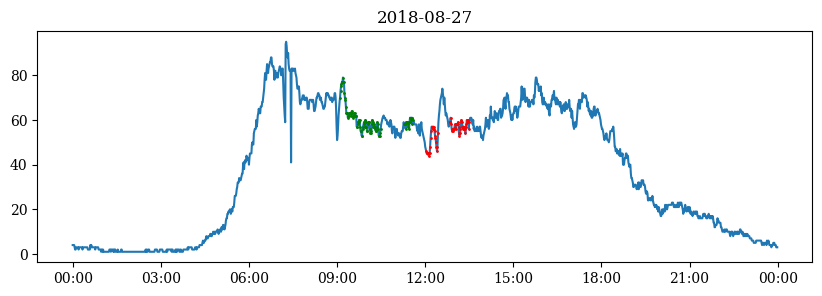

In [78]:
mpl.rcParams["lines.markersize"] = 2
def day_plot(df, idx):
    temp = df[df.index.date == date_ls[idx]]
    fig, ax = plt.subplots(figsize=(10,3))
    # Base Volume plot
    ax.plot(temp.Volume, zorder=1)
    ax.set_title(f'{date_ls[idx]}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    for i in range(0, len(temp)):
        if temp.Incident_Type1[i] != 'None1':
            ax.scatter(temp.index[i], temp.iloc[i, 1], zorder=2,
                      color = 'red', marker='.', label='Incident')
        elif temp.Incident_Type2[i] != 'None2':
            ax.scatter(temp.index[i], temp.iloc[i, 1], zorder=2,
                      color = 'red', marker='.', label='Incident')
        elif temp.Downstream_Incident[i] == 1:
            ax.scatter(temp.index[i], temp.iloc[i, 1], zorder=2,
                      color = 'green', marker='.')
    
    plt.show()

day_plot(df, 41)

In [68]:
#     for i in range(0, len(temp)):
#         if temp.Incident_Type1[i] != 'None1':
#             ax.scatter(temp.index[i], temp.iloc[i, 1], zorder=2,
#                       color = 'red', marker='*', label='Incident')
#         elif temp.Incident_Type2[i] != 'None2':
#             ax.scatter(temp.index[i], temp.iloc[i, 1], zorder=2,
#                       color = 'red', marker='*', label='Incident')

11.0

#### Link 1

In [15]:
df1 = df[df.ID==1]

In [16]:
df1.drop('ID', axis=1, inplace=True)
df1 = df1.set_index('DateTime')
df1.index = pd.to_datetime(df1.index)
if not df1.index.is_monotonic:
    df1 = df1.sort_index()

df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429120 entries, 2018-01-01 00:00:00 to 2018-10-25 23:59:00
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Length            429120 non-null  float64
 1   Volume            429120 non-null  float64
 2   Speed             429120 non-null  float64
 3   Occupancy         429120 non-null  float64
 4   Incident_Type     1301 non-null    object 
 5   TrafficCondition  1301 non-null    object 
dtypes: float64(4), object(2)
memory usage: 22.9+ MB


In [20]:
df1 = df1.loc['2018-08-27 08:30:00':'2018-08-27 13:30:00']

In [22]:
df1 = df1[['Volume']]

In [25]:
df1 = df1.groupby(df1.index.floor('15T').time).sum()

In [26]:
df1

,Volume
08:30:00,577.0
08:45:00,588.0
09:00:00,585.0
09:15:00,598.0
09:30:00,600.0
09:45:00,601.0
10:00:00,592.0
10:15:00,602.0
10:30:00,583.0
10:45:00,613.0


In [27]:
df1.to_csv('data/Link1_vol.csv')